In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# -------------------------------
# 0. Fijar semilla para replicabilidad
# -------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# 1. Cargar datos
df = pd.read_csv('../data/may14_feats4.csv', index_col=0)

# 2. Selección de features (solo TEMP, EDA y BVP)
selected_cols = [col for col in df.columns if any(sensor in col for sensor in ['EDA_', 'TEMP_', 'BVP_'])]
X = df[selected_cols]
y = df['label']

In [9]:
# División 70% train, 10% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=SEED)

In [10]:
# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE-Tomek
smote = SMOTETomek(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [11]:
# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Modelos y parámetros
param_distributions = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            'n_estimators': randint(100, 600),
            'max_depth': randint(3, 15),
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 5),
            'max_features': ['sqrt', 'log2']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=SEED),
        'params': {
            'C': uniform(0.1, 10),
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'poly']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': randint(3, 15),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=SEED),
        'params': {
            'n_estimators': randint(50, 300),
            'max_depth': randint(3, 10),
            'learning_rate': uniform(0.01, 0.2),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.6, 0.4),
            'gamma': uniform(0, 1),
            'min_child_weight': randint(1, 6)
        }
    }
}


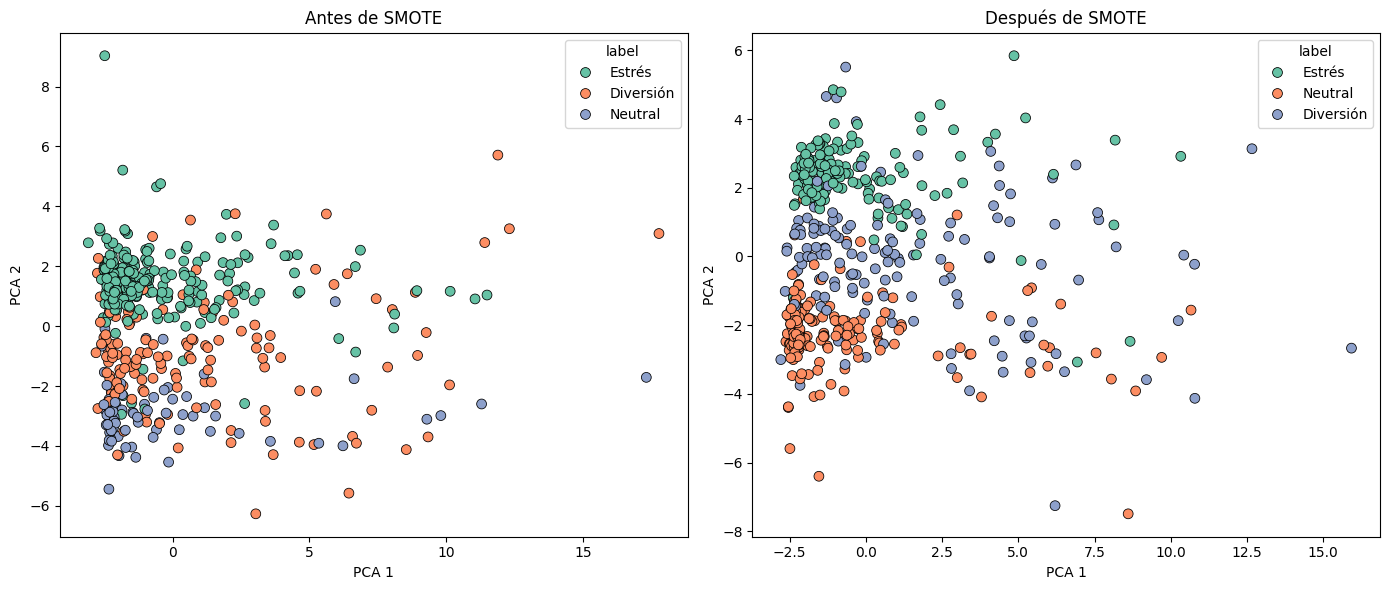

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Mapeo correcto basado en WESAD
label_map = {
    0: 'Neutral',
    1: 'Estrés',
    2: 'Diversión'
}

# PCA por separado
pca_before = PCA(n_components=2, random_state=SEED)
pca_after = PCA(n_components=2, random_state=SEED)

# Reducimos dimensiones
X_pca_before = pca_before.fit_transform(X_train_scaled[:len(y_train)])
X_pca_after = pca_after.fit_transform(X_train_resampled[:len(y_train_resampled)])

# Crear DataFrames
df_before = pd.DataFrame({
    'PCA1': X_pca_before[:, 0],
    'PCA2': X_pca_before[:, 1],
    'label': y_train.values
})

df_after = pd.DataFrame({
    'PCA1': X_pca_after[:, 0],
    'PCA2': X_pca_after[:, 1],
    'label': y_train_resampled
})

# Aplicar mapeo de etiquetas
df_before['label'] = df_before['label'].replace(label_map)
df_after['label'] = df_after['label'].replace(label_map)

# Muestreo para visualizar menos puntos
df_before_sampled = df_before.sample(n=500, random_state=SEED)
df_after_sampled = df_after.sample(n=500, random_state=SEED)

# Graficar
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_before_sampled, x='PCA1', y='PCA2', hue='label', palette='Set2', edgecolor='k', s=50)
plt.title('Antes de SMOTE')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_after_sampled, x='PCA1', y='PCA2', hue='label', palette='Set2', edgecolor='k', s=50)
plt.title('Después de SMOTE')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()



 Random Forest - búsqueda de hiperparámetros
Mejores hiperparámetros: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 158}
Accuracy: 0.8953 | F1-macro: 0.8853
              precision    recall  f1-score   support

   Amusement       0.83      0.93      0.88       120
    Baseline       0.96      0.90      0.93       381
      Stress       0.83      0.87      0.85       215

    accuracy                           0.90       716
   macro avg       0.87      0.90      0.89       716
weighted avg       0.90      0.90      0.90       716


 SVM - búsqueda de hiperparámetros
Mejores hiperparámetros: {'C': 9.715133389830848, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.8785 | F1-macro: 0.8637
              precision    recall  f1-score   support

   Amusement       0.80      0.91      0.85       120
    Baseline       0.94      0.90      0.92       381
      Stress       0.82      0.82      0.82       215

    accuracy                

c:\Users\Lord\anaconda3\envs\Prueba\lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'colsample_bytree': 0.8087739856258308, 'gamma': 0.15534330251001693, 'learning_rate': 0.143322677318857, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 127, 'subsample': 0.6731330253939652}
Accuracy: 0.9120 | F1-macro: 0.9018
              precision    recall  f1-score   support

   Amusement       0.87      0.92      0.89       120
    Baseline       0.96      0.92      0.94       381
      Stress       0.86      0.89      0.87       215

    accuracy                           0.91       716
   macro avg       0.89      0.91      0.90       716
weighted avg       0.91      0.91      0.91       716



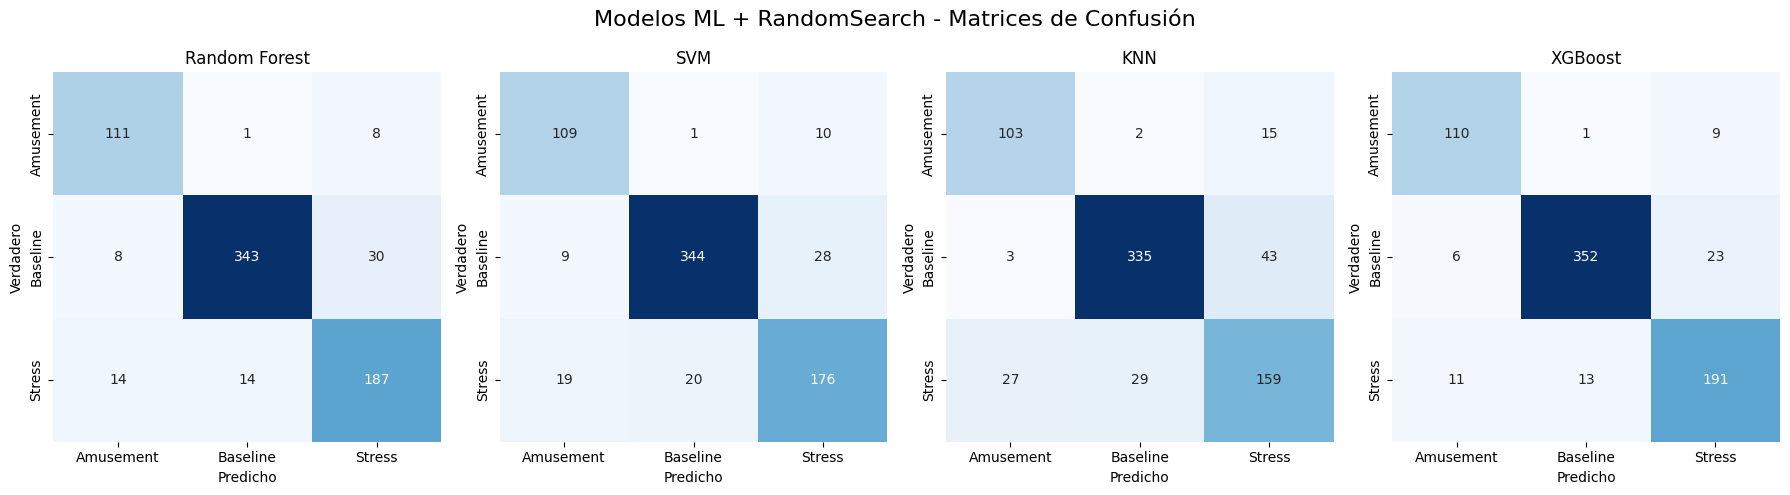

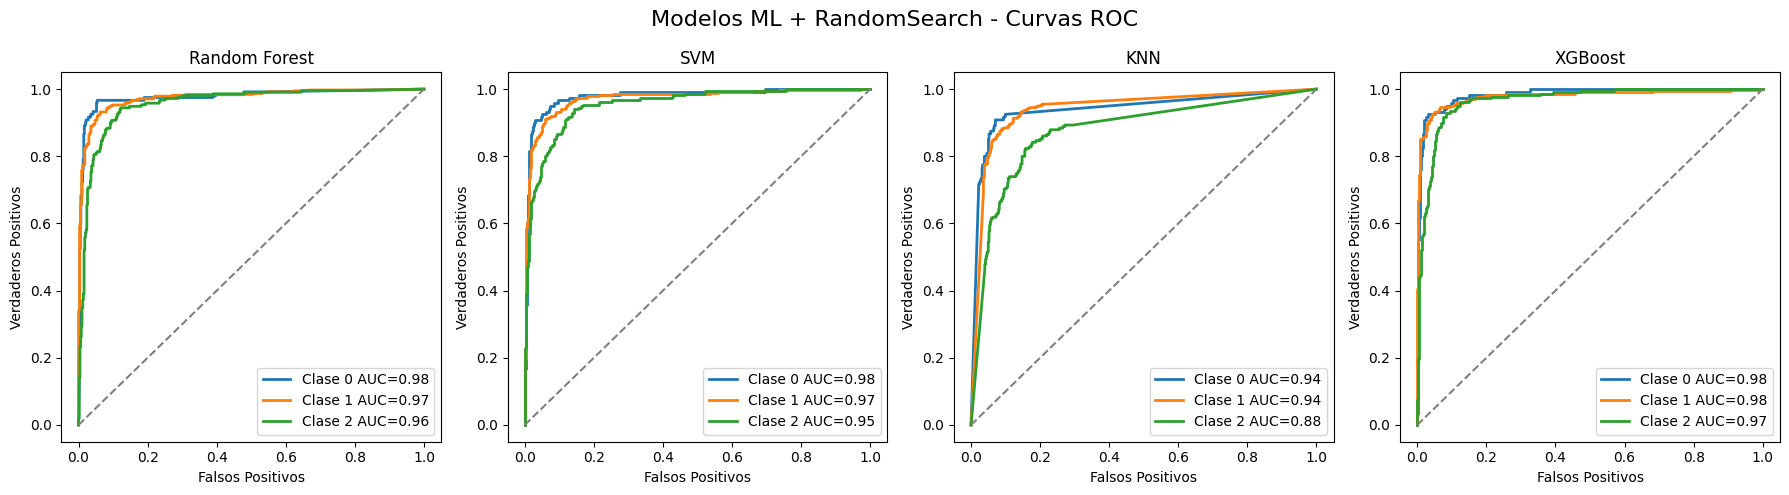

,Model,Best Params,Accuracy,F1_macro
0,Random Forest,"{'max_depth': 14, 'max_features': 'sqrt', 'min...",0.895251,0.885251
1,SVM,"{'C': 9.715133389830848, 'gamma': 'auto', 'ker...",0.878492,0.863671
2,KNN,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.833799,0.815754
3,XGBoost,"{'colsample_bytree': 0.8087739856258308, 'gamm...",0.912011,0.901757


In [13]:
# Funciones de visualización
def plot_confusion_matrices(y_true_list, y_pred_list, model_names, scenario):
    fig, axes = plt.subplots(1, len(model_names), figsize=(18, 5))
    fig.suptitle(f"{scenario} - Matrices de Confusión", fontsize=16)
    for i, (y_true, y_pred, name) in enumerate(zip(y_true_list, y_pred_list, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i],
                    xticklabels=['Amusement', 'Baseline', 'Stress'],
                    yticklabels=['Amusement', 'Baseline', 'Stress'])
        axes[i].set_title(name)
        axes[i].set_xlabel("Predicho")
        axes[i].set_ylabel("Verdadero")
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true_list, y_proba_list, model_names, scenario):
    fig, axes = plt.subplots(1, len(model_names), figsize=(18, 5))
    fig.suptitle(f"{scenario} - Curvas ROC", fontsize=16)
    for i, (y_true, y_proba, name) in enumerate(zip(y_true_list, y_proba_list, model_names)):
        if y_proba is not None:
            y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
            for j in range(3):
                fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_proba[:, j])
                roc_auc = auc(fpr, tpr)
                axes[i].plot(fpr, tpr, lw=2, label=f'Clase {j} AUC={roc_auc:.2f}')
            axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
            axes[i].set_title(name)
            axes[i].set_xlabel("Falsos Positivos")
            axes[i].set_ylabel("Verdaderos Positivos")
            axes[i].legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Entrenamiento y evaluación
results = []
y_true_list, y_pred_list, y_proba_list, model_names = [], [], [], []

for model_name, config in param_distributions.items():
    print(f"\n {model_name} - búsqueda de hiperparámetros")
    search = RandomizedSearchCV(config['model'], config['params'], n_iter=20, scoring='f1_macro',
                                cv=cv, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled) if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Mejores hiperparámetros: {search.best_params_}")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Amusement', 'Baseline', 'Stress']))

    results.append({
        'Model': model_name,
        'Best Params': search.best_params_,
        'Accuracy': acc,
        'F1_macro': f1
    })

    y_true_list.append(y_test)
    y_pred_list.append(y_pred)
    y_proba_list.append(y_proba)
    model_names.append(model_name)

# Visualización final
plot_confusion_matrices(y_true_list, y_pred_list, model_names, "Modelos ML + RandomSearch")
plot_roc_curves(y_true_list, y_proba_list, model_names, "Modelos ML + RandomSearch")

# Mostrar resumen
results_df = pd.DataFrame(results)
display(results_df)